In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Định nghĩa tên các cột theo tài liệu UCI
columns = [
    "Pregnancies",            # Số lần mang thai
    "Glucose",                # Nồng độ glucose huyết tương
    "BloodPressure",          # Huyết áp tâm trương
    "SkinThickness",          # Độ dày nếp gấp da (mm)
    "Insulin",                # Insulin huyết thanh (mu U/ml)
    "BMI",                    # Chỉ số khối cơ thể
    "DiabetesPedigreeFunction", # Hàm phả hệ tiểu đường (yếu tố di truyền)
    "Age",                    # Tuổi
    "Outcome"                 # Kết quả (0: Không mắc, 1: Mắc tiểu đường)
]
# Đọc dataset Pima Indians Diabetes
df = pd.read_csv("pima-indians-diabetes.csv", header=None, names=columns)

In [8]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [10]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [13]:
# NGƯỠNG RỘNG ĐỂ BẢO TOÀN DỮ LIỆU - CHỈ LỌC GIÁ TRỊ VÔ LÝ THỰC SỰ
physiological_ranges = {
    'Pregnancies': (0, 20),           # Số lần mang thai hợp lý
    'Glucose': (20, 300),             # Cho phép cả giá trị bệnh lý cao
    'BloodPressure': (40, 200),       # Bao gồm cả tăng huyết áp nặng
    'BMI': (10, 80),                  # Bao gồm cả béo phì bệnh lý
    'Age': (21, 100)                  # Tuổi hợp lý cho nghiên cứu
     # Với các chỉ số khác, có thể chỉ xử lý giá trị 0
}

In [14]:
def detect_physiological_errors(df, ranges):
    """Phát hiện dữ liệu ngoài ngưỡng sinh lý"""
    errors = {}
    
    for column, (min_val, max_val) in ranges.items():
        # Tìm các giá trị ngoài ngưỡng
        out_of_range = (df[column] < min_val) | (df[column] > max_val)
        error_count = out_of_range.sum()
        
        if error_count > 0:
            errors[column] = {
                'count': error_count,
                'min_actual': df[column].min(),
                'max_actual': df[column].max(),
                'problem_values': df[column][out_of_range].unique()
            }
    
    return errors

# Phát hiện lỗi
errors = detect_physiological_errors(df, physiological_ranges)
print("=== DỮ LIỆU LỖI PHÁT HIỆN ===")
for col, info in errors.items():
    print(f"{col}: {info['count']} giá trị lỗi")
    print(f"  - Range thực tế: {info['min_actual']} - {info['max_actual']}")
    print(f"  - Giá trị có vấn đề: {info['problem_values']}")

=== DỮ LIỆU LỖI PHÁT HIỆN ===
Glucose: 5 giá trị lỗi
  - Range thực tế: 0 - 199
  - Giá trị có vấn đề: [0]
BloodPressure: 39 giá trị lỗi
  - Range thực tế: 0 - 122
  - Giá trị có vấn đề: [ 0 30 24 38]
BMI: 11 giá trị lỗi
  - Range thực tế: 0.0 - 67.1
  - Giá trị có vấn đề: [0.]


In [15]:
# Chiến lược: XÓA các dòng có dữ liệu lỗi nghiêm trọng
def clean_physiological_errors(df, ranges):
    """Xóa dòng có dữ liệu ngoài ngưỡng sinh lý"""
    
    # Tạo mask để đánh dấu dòng lỗi
    error_mask = pd.Series(False, index=df.index)
    
    # Các chỉ số QUAN TRỌNG cần xử lý nghiêm ngặt
    critical_columns = ['Glucose', 'BloodPressure', 'BMI', 'Age']
    
    for column in critical_columns:
        min_val, max_val = ranges[column]
        # Đánh dấu dòng có giá trị ngoài ngưỡng
        error_mask |= (df[column] < min_val) | (df[column] > max_val)
    
    print(f"Số dòng có dữ liệu lỗi nghiêm trọng: {error_mask.sum()}")
    
    # Giữ lại các dòng KHÔNG có lỗi
    df_clean = df[~error_mask].copy()
    
    return df_clean

# Xử lý dữ liệu lỗi
df_clean = clean_physiological_errors(df, physiological_ranges)

Số dòng có dữ liệu lỗi nghiêm trọng: 48


In [16]:
# Sau khi xử lý lỗi nghiêm trọng, xử lý giá trị 0
def handle_zero_values(df):
    """Xử lý giá trị 0 bất thường trong các chỉ số sinh học"""
    
    # Các cột không được phép có giá trị 0
    zero_sensitive_columns = ['Insulin', 'SkinThickness']
    
    for col in zero_sensitive_columns:
        zero_mask = df[col] == 0
        if zero_mask.any():
            print(f"Phát hiện {zero_mask.sum()} giá trị 0 trong {col}")
            
            # Thay thế bằng median của cột (không bao gồm giá trị 0)
            median_val = df[col][df[col] > 0].median()
            df.loc[zero_mask, col] = median_val
            print(f"  → Đã thay thế bằng median: {median_val:.2f}")
    
    return df

# Xử lý giá trị 0
df_final = handle_zero_values(df_clean)

Phát hiện 332 giá trị 0 trong Insulin
  → Đã thay thế bằng median: 126.00
Phát hiện 192 giá trị 0 trong SkinThickness
  → Đã thay thế bằng median: 29.00


In [17]:
print("=== KẾT QUẢ SAU XỬ LÝ ===")
print(f"Dữ liệu gốc: {len(df)} dòng")
print(f"Sau xử lý: {len(df_final)} dòng")
print(f"Tỷ lệ giữ lại: {len(df_final)/len(df)*100:.1f}%")

# Kiểm tra lại ngưỡng sinh lý
final_errors = detect_physiological_errors(df_final, physiological_ranges)
if not final_errors:
    print("✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý")
else:
    print("❌ Vẫn còn dữ liệu lỗi:")
    for col, info in final_errors.items():
        print(f"  - {col}: {info['count']} lỗi")

=== KẾT QUẢ SAU XỬ LÝ ===
Dữ liệu gốc: 768 dòng
Sau xử lý: 720 dòng
Tỷ lệ giữ lại: 93.8%
✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý


In [18]:
# Thống kê mô tả cơ bản
stats = df_final.describe().T  # chuyển thành bảng với biến số theo hàng

# Thêm cột Median
stats["median"] = df_final.median()

# Chọn cột cần hiển thị
stats = stats[["mean", "std", "min", "max", "median"]]

# Làm tròn cho đẹp
stats = stats.round(2)

print(stats)

# Số lượng bản ghi còn lại sau xử lý
print("\nKích thước dataset sau xử lý:", df_final.shape)


                            mean    std    min     max  median
Pregnancies                 3.88   3.37   0.00   17.00    3.00
Glucose                   122.02  30.77  44.00  199.00  117.00
BloodPressure              72.63  12.01  40.00  122.00   72.00
SkinThickness              29.13   9.01   7.00   99.00   29.00
Insulin                   142.61  88.76  14.00  846.00  126.00
BMI                        32.44   6.83  18.20   67.10   32.40
DiabetesPedigreeFunction    0.48   0.33   0.08    2.42    0.38
Age                        33.39  11.78  21.00   81.00   29.00
Outcome                     0.34   0.48   0.00    1.00    0.00

Kích thước dataset sau xử lý: (720, 9)


In [25]:
(df_final["Age"]>50).sum()

np.int64(78)

# CHƯƠNG 4: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)

## PHÂN TÍCH ĐƠN BIẾN

### Phân bố của từng biến số

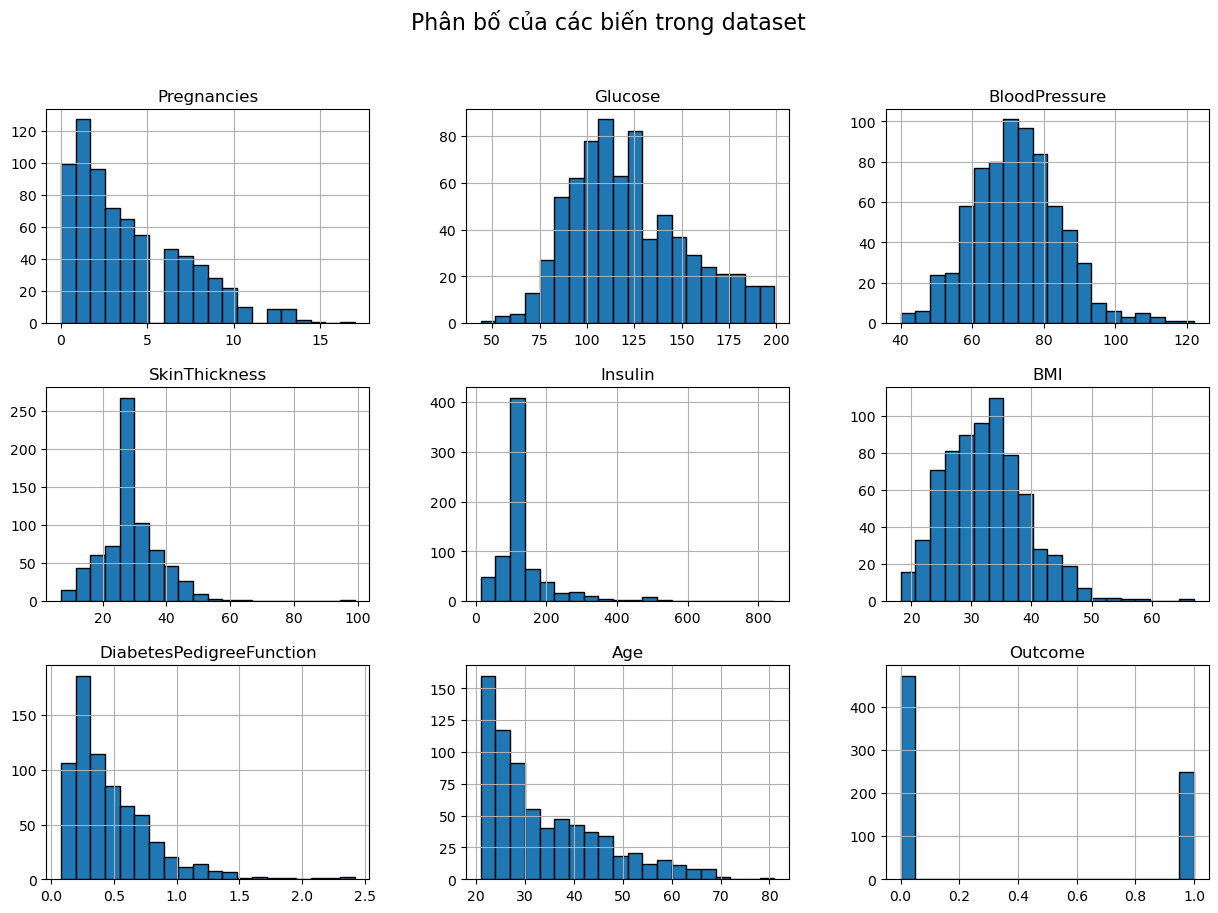

In [92]:
df_final.hist(bins=20, figsize=(15,10), edgecolor="black")
plt.suptitle("Phân bố của các biến trong dataset", fontsize=16)
plt.savefig('4.1.1.png', dpi=300, bbox_inches='tight')
plt.show()

### Phát hiện các giá trị ngoại lệ và bất thường

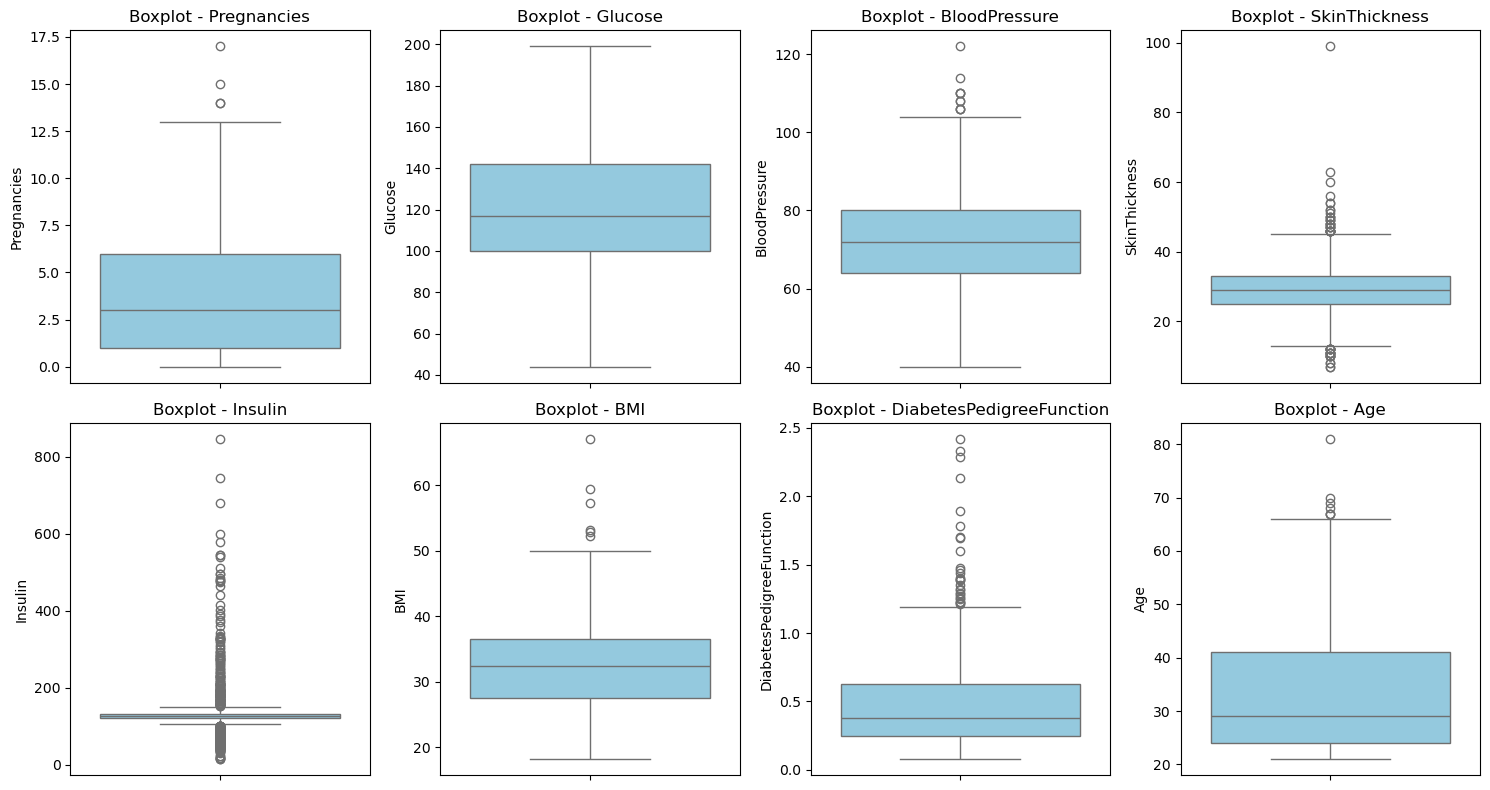

In [13]:
plt.figure(figsize=(15,8))   # Kích thước toàn bộ figure

# Lặp qua các cột, bỏ cột cuối (Outcome)
for i, col in enumerate(df_final.columns[:-1], 1):
    plt.subplot(2,4,i)   # Chia thành lưới 2 hàng 4 cột, vẽ lần lượt
    sns.boxplot(y=df_final[col], color="skyblue")  # Boxplot theo cột
    plt.title(f"Boxplot - {col}")  # Đặt tiêu đề cho mỗi subplot

plt.tight_layout()   # Canh chỉnh bố cục gọn gàng
plt.savefig('4.1.2.png')  # Lưu hình
plt.show()  # Hiển thị

## PHÂN TÍCH BIẾN MỤC TIÊU

### Tỷ lệ mắc bệnh đái tháo đường

C:\Users\boeot\AppData\Local\Temp\ipykernel_14268\3135907679.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Outcome", data=df_final, palette="Set2")


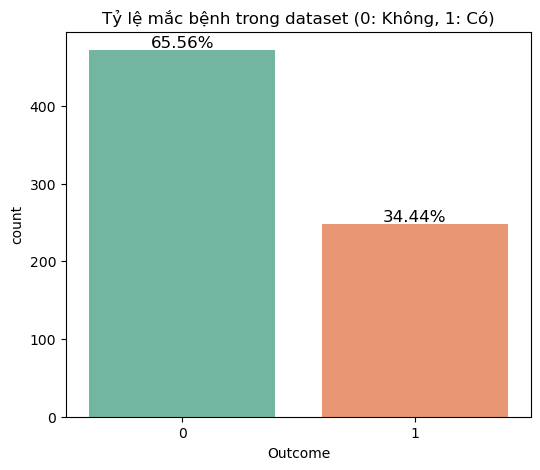

In [15]:
plt.figure(figsize=(6,5))
ax = sns.countplot(x="Outcome", data=df_final, palette="Set2")
plt.title("Tỷ lệ mắc bệnh trong dataset (0: Không, 1: Có)")

# Thêm nhãn phần trăm trên từng cột
total = len(df_final)
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.2f}%', 
                (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='bottom', fontsize=12)

plt.savefig('4.2.1.png', dpi=300, bbox_inches='tight')
plt.show()


### Đặc điểm nhóm bệnh nhân và nhóm khỏe mạnh

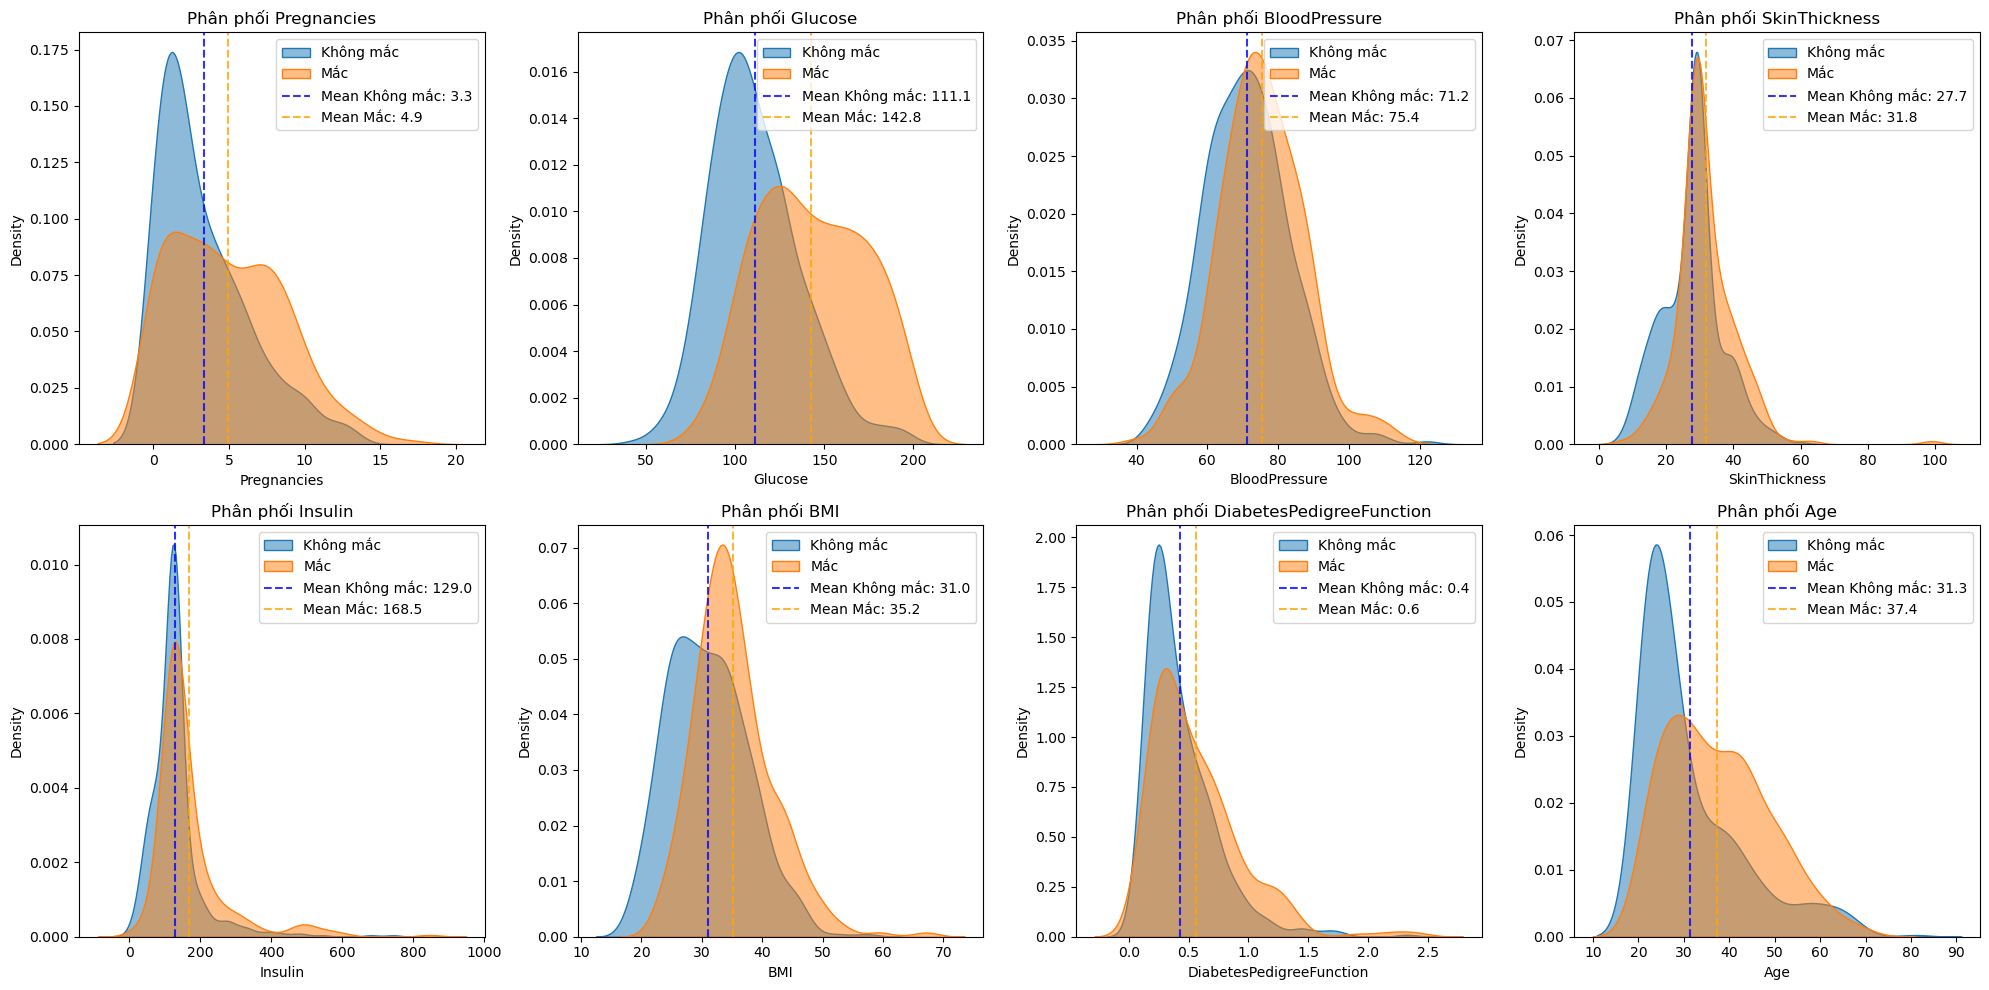

In [23]:
# Danh sách tất cả các biến cần vẽ
all_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
               'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Tạo figure lớn để chứa tất cả biểu đồ
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()  # Chuyển thành mảng 1 chiều

for i, column in enumerate(all_columns):
    # Vẽ density plot cho 2 nhóm
    sns.kdeplot(data=df_final[df_final['Outcome'] == 0][column], 
                label='Không mắc', fill=True, alpha=0.5, ax=axes[i])
    sns.kdeplot(data=df_final[df_final['Outcome'] == 1][column], 
                label='Mắc', fill=True, alpha=0.5, ax=axes[i])
    
    # Thêm đường mean cho từng nhóm
    mean_0 = df_final[df_final['Outcome'] == 0][column].mean()
    mean_1 = df_final[df_final['Outcome'] == 1][column].mean()
    
    axes[i].axvline(mean_0, color='blue', linestyle='--', alpha=0.8, label=f'Mean Không mắc: {mean_0:.1f}')
    axes[i].axvline(mean_1, color='orange', linestyle='--', alpha=0.8, label=f'Mean Mắc: {mean_1:.1f}')
    
    axes[i].set_title(f'Phân phối {column}')
    axes[i].set_xlabel(column)
    axes[i].legend()

plt.tight_layout()
plt.savefig('4.2.2.png', dpi=300, bbox_inches='tight')
plt.show()

## PHÂN TÍCH THEO NHÓM TUỔI

### Phân bố bệnh theo độ tuổi

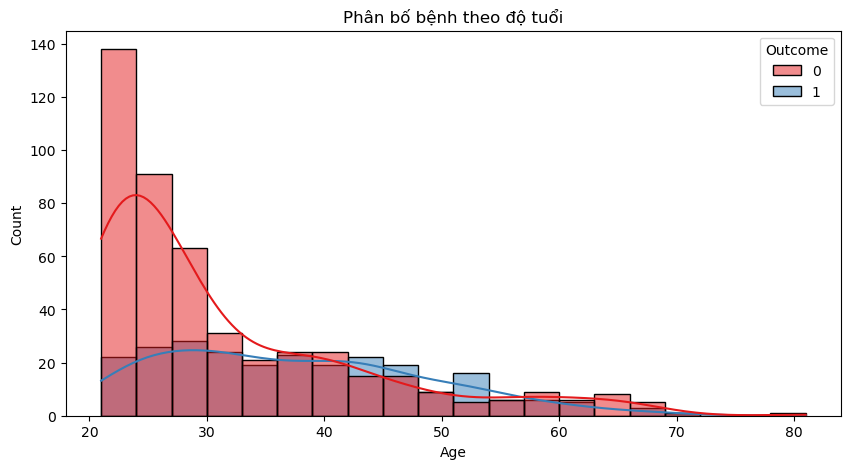

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_final, x="Age", hue="Outcome", bins=20, kde=True, palette="Set1")
plt.title("Phân bố bệnh theo độ tuổi")
plt.savefig('4.3.1.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Tạo nhóm tuổi thủ công theo số liệu của bạn
def create_age_group(age):
    if age <= 30:
        return '21-30 tuổi'
    elif age <= 40:
        return '31-40 tuổi' 
    elif age <= 50:
        return '41-50 tuổi'
    else:
        return '>50 tuổi'

df_final['Age_Group_Custom'] = df_final['Age'].apply(create_age_group)

# Kiểm tra
print("=== NHÓM TUỔI TÙY CHỈNH ===")
custom_counts = df_final['Age_Group_Custom'].value_counts().sort_index()
print(custom_counts)

# Tính tỷ lệ
custom_analysis = df_final.groupby('Age_Group_Custom').agg(
    total=('Outcome', 'count'),
    diabetes_cases=('Outcome', 'sum')
)
custom_analysis['diabetes_rate'] = (custom_analysis['diabetes_cases'] / custom_analysis['total'] * 100).round(1)

print("\n=== KẾT QUÁ TÙY CHỈNH ===")
for age_group in ['21-30 tuổi', '31-40 tuổi', '41-50 tuổi', '>50 tuổi']:
    if age_group in custom_analysis.index:
        data = custom_analysis.loc[age_group]
        print(f"{age_group}: {data['diabetes_rate']}% tỷ lệ mắc bệnh (n={data['total']})")

=== NHÓM TUỔI TÙY CHỈNH ===
Age_Group_Custom
21-30 tuổi    387
31-40 tuổi    147
41-50 tuổi    108
>50 tuổi       78
Name: count, dtype: int64

=== KẾT QUÁ TÙY CHỈNH ===
21-30 tuổi: 20.7% tỷ lệ mắc bệnh (n=387.0)
31-40 tuổi: 47.6% tỷ lệ mắc bệnh (n=147.0)
41-50 tuổi: 56.5% tỷ lệ mắc bệnh (n=108.0)
>50 tuổi: 47.4% tỷ lệ mắc bệnh (n=78.0)


### Các chỉ số sinh lý thay đổi theo tuổi

In [22]:
# Tạo nhóm tuổi chi tiết hơn để phân tích
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '>60']
df_final['Age_Group_Detail'] = pd.cut(df_final['Age'], bins=bins, labels=labels, right=False)

# Tính giá trị trung bình theo nhóm tuổi
age_trends = df_final.groupby('Age_Group_Detail').agg({
    'BMI': 'mean',
    'Glucose': 'mean', 
    'BloodPressure': 'mean',
    'Age': 'count'
}).round(2)

age_trends = age_trends.rename(columns={'Age': 'Sample_Count'})

print("=== THỐNG KÊ CHỈ SỐ THEO NHÓM TUỔI ===")
print(age_trends)

=== THỐNG KÊ CHỈ SỐ THEO NHÓM TUỔI ===
                    BMI  Glucose  BloodPressure  Sample_Count
Age_Group_Detail                                             
20-25             31.00   113.04          67.75           204
26-30             33.49   117.63          70.95           164
31-35             32.27   124.71          72.35            85
36-40             33.09   128.16          75.87            69
41-45             34.52   125.71          75.79            68
46-50             33.88   124.32          79.61            44
51-55             33.14   142.88          82.03            34
56-60             29.98   136.95          75.64            22
>60               29.70   138.97          78.13            30


C:\Users\boeot\AppData\Local\Temp\ipykernel_14908\1521796606.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_trends = df_final.groupby('Age_Group_Detail').agg({


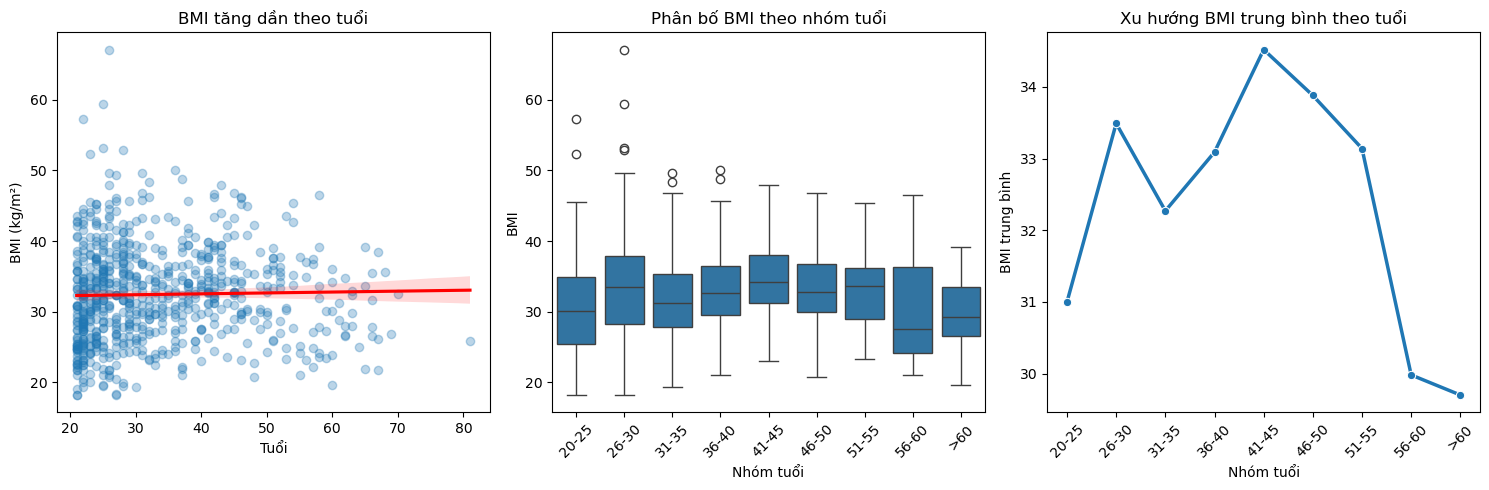

In [23]:
# Biểu đồ 1: BMI thay đổi theo tuổi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.regplot(data=df_final, x='Age', y='BMI', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('BMI tăng dần theo tuổi')
plt.xlabel('Tuổi')
plt.ylabel('BMI (kg/m²)')

# Thêm boxplot theo nhóm tuổi
plt.subplot(1, 3, 2)
sns.boxplot(data=df_final, x='Age_Group_Detail', y='BMI')
plt.title('Phân bố BMI theo nhóm tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('BMI')
plt.xticks(rotation=45)

# Đường trend BMI theo tuổi
plt.subplot(1, 3, 3)
sns.lineplot(data=age_trends, x=age_trends.index, y='BMI', marker='o', linewidth=2.5)
plt.title('Xu hướng BMI trung bình theo tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('BMI trung bình')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('4.3.2_BMI_theo_tuoi.png', dpi=300, bbox_inches='tight')
plt.show()

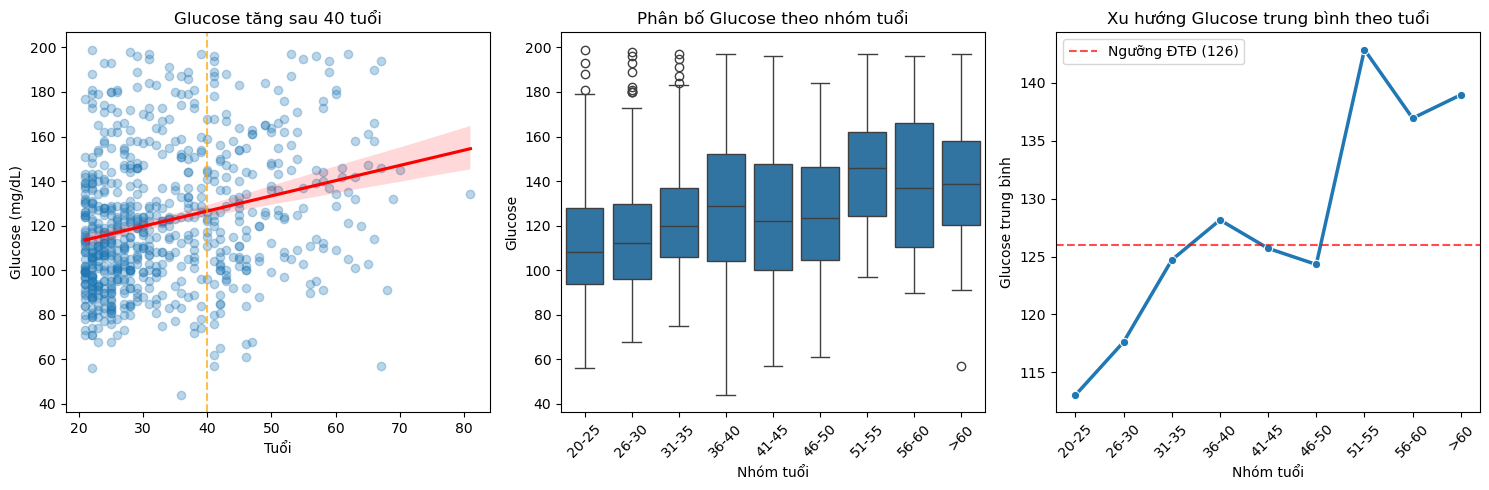

In [30]:
# Biểu đồ 2: Glucose thay đổi theo tuổi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.regplot(data=df_final, x='Age', y='Glucose', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Glucose tăng sau 40 tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Glucose (mg/dL)')
plt.axvline(x=40, color='orange', linestyle='--', alpha=0.7, label='Tuổi 40')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_final, x='Age_Group_Detail', y='Glucose')
plt.title('Phân bố Glucose theo nhóm tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Glucose')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.lineplot(data=age_trends, x=age_trends.index, y='Glucose', marker='o', linewidth=2.5)
plt.axhline(y=126, color='red', linestyle='--', alpha=0.7, label='Ngưỡng ĐTĐ (126)')
plt.title('Xu hướng Glucose trung bình theo tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Glucose trung bình')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('4.3.2_Glucose_theo_tuoi.png', dpi=300, bbox_inches='tight')
plt.show()

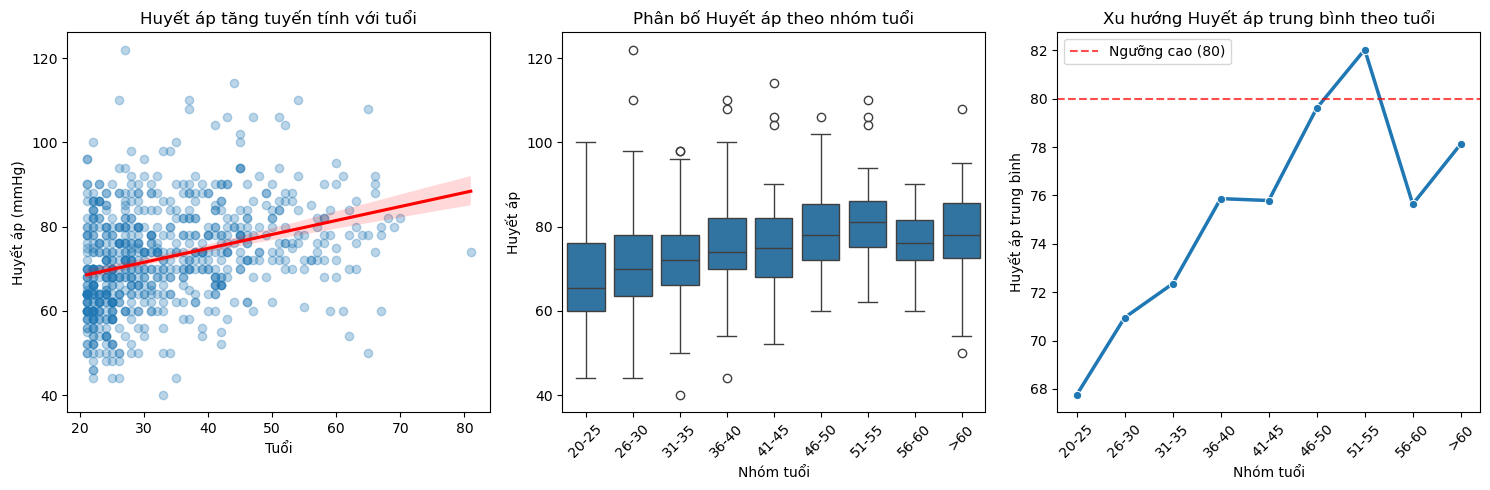

In [24]:
# Biểu đồ 3: Huyết áp thay đổi theo tuổi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.regplot(data=df_final, x='Age', y='BloodPressure', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Huyết áp tăng tuyến tính với tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Huyết áp (mmHg)')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_final, x='Age_Group_Detail', y='BloodPressure')
plt.title('Phân bố Huyết áp theo nhóm tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Huyết áp')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.lineplot(data=age_trends, x=age_trends.index, y='BloodPressure', marker='o', linewidth=2.5)
plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Ngưỡng cao (80)')
plt.title('Xu hướng Huyết áp trung bình theo tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Huyết áp trung bình')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('4.3.2_Huyet_ap_theo_tuoi.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Tạo nhóm tuổi chi tiết
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
labels = ['20-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '>60']
df_final['Age_Group_Detail'] = pd.cut(df_final['Age'], bins=bins, labels=labels, right=False)

# Tính toán các chỉ số theo nhóm tuổi
age_group_stats = df_final.groupby('Age_Group_Detail').agg({
    'BMI': ['mean', 'std'],
    'Glucose': ['mean', 'std'],
    'BloodPressure': ['mean', 'std'],
    'Age': 'count'
}).round(2)

# Làm phẳng multi-index columns
age_group_stats.columns = ['BMI_mean', 'BMI_std', 'Glucose_mean', 'Glucose_std', 
                          'BloodPressure_mean', 'BloodPressure_std', 'Sample_Count']

# Tạo bảng đẹp cho báo cáo
table_4_3_2 = age_group_stats[['BMI_mean', 'Glucose_mean', 'BloodPressure_mean', 'Sample_Count']]
table_4_3_2 = table_4_3_2.rename(columns={
    'BMI_mean': 'BMI (kg/m²)',
    'Glucose_mean': 'Glucose (mg/dL)',
    'BloodPressure_mean': 'Huyết áp (mmHg)',
    'Sample_Count': 'Mẫu số'
})

print("BẢNG 4.3.2: GIÁ TRỊ TRUNG BÌNH THEO NHÓM TUỔI")
print("="*65)
print(table_4_3_2)
print("="*65)

BẢNG 4.3.2: GIÁ TRỊ TRUNG BÌNH THEO NHÓM TUỔI
                  BMI (kg/m²)  Glucose (mg/dL)  Huyết áp (mmHg)  Mẫu số
Age_Group_Detail                                                       
20-25                   31.00           113.04            67.75     204
26-30                   33.49           117.63            70.95     164
31-35                   32.27           124.71            72.35      85
36-40                   33.09           128.16            75.87      69
41-45                   34.52           125.71            75.79      68
46-50                   33.88           124.32            79.61      44
51-55                   33.14           142.88            82.03      34
56-60                   29.98           136.95            75.64      22
>60                     29.70           138.97            78.13      30


C:\Users\boeot\AppData\Local\Temp\ipykernel_14908\3209526691.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = df_final.groupby('Age_Group_Detail').agg({


### Yếu tố nguy cơ ở từng nhóm tuổi

In [27]:
age_outcome = df_final.groupby("AgeGroup")["Outcome"].mean()
print(age_outcome)
age_outcome.plot(kind="bar", color="tomato", title="Tỷ lệ mắc bệnh theo nhóm tuổi")
plt.savefig('4.3.3.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'AgeGroup'

## PHÂN TÍCH THEO CHỈ SỐ BMI

### Phân loại BMI và tỷ lệ mắc bệnh

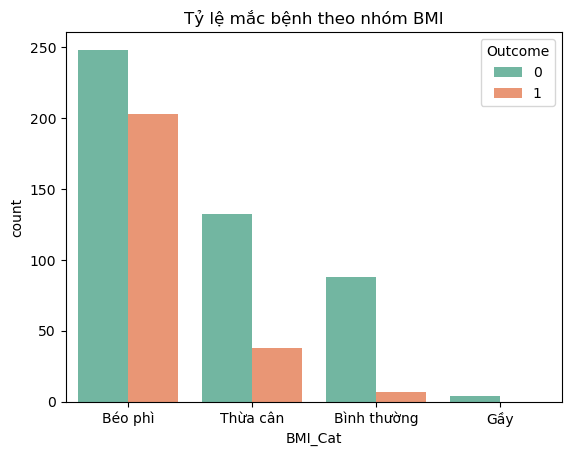

In [101]:
def bmi_category(bmi):
    if bmi < 18.5: return "Gầy"
    elif bmi < 25: return "Bình thường"
    elif bmi < 30: return "Thừa cân"
    else: return "Béo phì"

df_final["BMI_Cat"] = df_final["BMI"].apply(bmi_category)

sns.countplot(x="BMI_Cat", hue="Outcome", data=df_final, palette="Set2")
plt.title("Tỷ lệ mắc bệnh theo nhóm BMI")
plt.savefig('4.4.1.png', dpi=300, bbox_inches='tight')
plt.show()

,Tổng số,Số ca mắc,Tỷ lệ mắc (%),BMI trung bình,Glucose trung bình (mg/dL),Tuổi trung bình
BMI_Cat,,,,,,
Gầy,4,0,0.0%,18.2,95.250000,24.0
Bình thường,95,7,7.0%,22.8,109.490000,31.9
Thừa cân,170,38,22.0%,27.5,117.190000,33.1
Béo phì,451,203,45.0%,36.5,126.720000,33.9


### Mối quan hệ giữa béo phì và đái tháo đường

In [29]:
# 1. ĐỊNH NGHĨA HÀM PHÂN LOẠI BMI
def bmi_category(bmi):
    if bmi < 18.5: 
        return "Gầy"
    elif bmi < 25: 
        return "Bình thường"
    elif bmi < 30: 
        return "Thừa cân"
    else: 
        return "Béo phì"

# 2. TẠO CỘT BMI_Cat
df_final['BMI_Cat'] = df_final['BMI'].apply(bmi_category)

# 3. KIỂM TRA CÁC GIÁ TRỊ ĐÃ TẠO
print("Phân bố các nhóm BMI:")
print(df_final['BMI_Cat'].value_counts())

# 4. BÂY GIỜ CHẠY LẠI CROSSTAB
bmi_outcome = pd.crosstab(df_final["BMI_Cat"], df_final["Outcome"], normalize="index")
print("\nTỷ lệ mắc bệnh theo nhóm BMI:")
print(bmi_outcome)

# 5. ĐỊNH DẠNG ĐẸP HƠN
bmi_outcome_percent = (bmi_outcome * 100).round(1)
print("\nTỷ lệ mắc bệnh theo nhóm BMI (%):")
print(bmi_outcome_percent)

Phân bố các nhóm BMI:
BMI_Cat
Béo phì        451
Thừa cân       170
Bình thường     95
Gầy              4
Name: count, dtype: int64

Tỷ lệ mắc bệnh theo nhóm BMI:
Outcome             0         1
BMI_Cat                        
Béo phì      0.549889  0.450111
Bình thường  0.926316  0.073684
Gầy          1.000000  0.000000
Thừa cân     0.776471  0.223529

Tỷ lệ mắc bệnh theo nhóm BMI (%):
Outcome          0     1
BMI_Cat                 
Béo phì       55.0  45.0
Bình thường   92.6   7.4
Gầy          100.0   0.0
Thừa cân      77.6  22.4


In [28]:
pd.crosstab(df_final["BMI_Cat"], df_final["Outcome"], normalize="index")

KeyError: 'BMI_Cat'

In [32]:
# 4.4.2 MỐI QUAN HỆ GIỮA BÉO PHÌ VÀ ĐÁI THÁO ĐƯỜNG
print("=== PHÂN TÍCH MỐI QUAN HỆ BMI VÀ ĐÁI THÁO ĐƯỜNG ===")

# Kiểm định sự khác biệt BMI giữa 2 nhóm
bmi_healthy = df_final[df_final['Outcome'] == 0]['BMI']
bmi_diabetes = df_final[df_final['Outcome'] == 1]['BMI']

t_stat, p_value = stats.ttest_ind(bmi_diabetes, bmi_healthy)
print(f"Kiểm định t: t = {t_stat:.3f}, p-value = {p_value:.4f}")

# Tính OR (Odds Ratio) cho béo phì
obese_mask = df_final['BMI'] >= 30
obese_diabetes = df_final[obese_mask]['Outcome'].mean()
non_obese_diabetes = df_final[~obese_mask]['Outcome'].mean()

odds_ratio = (obese_diabetes / (1 - obese_diabetes)) / (non_obese_diabetes / (1 - non_obese_diabetes))
print(f"Odds Ratio (Béo phì vs Không béo phì): {odds_ratio:.2f}")

# Tính correlation
correlation = df_final['BMI'].corr(df_final['Outcome'])
print(f"Hệ số tương quan BMI - Outcome: {correlation:.3f}")

=== PHÂN TÍCH MỐI QUAN HỆ BMI VÀ ĐÁI THÁO ĐƯỜNG ===
Kiểm định t: t = 8.321, p-value = 0.0000
Odds Ratio (Béo phì vs Không béo phì): 4.07
Hệ số tương quan BMI - Outcome: 0.297


### BMI kết hợp với các yếu tố khác

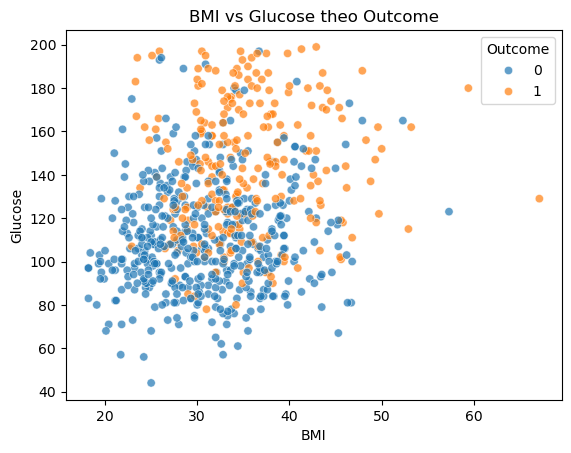

In [102]:
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_final, alpha=0.7)
plt.title("BMI vs Glucose theo Outcome")
plt.savefig('4.4.3.png', dpi=300, bbox_inches='tight')
plt.show()

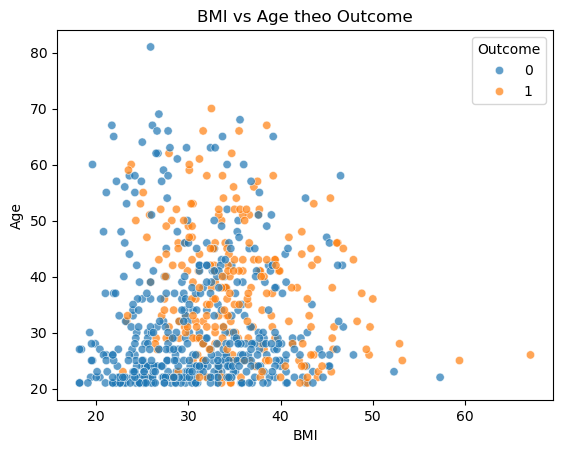

In [40]:
sns.scatterplot(x="BMI", y="Age", hue="Outcome", data=df_final, alpha=0.7)
plt.title("BMI vs Age theo Outcome")
plt.savefig('4.4.3_age.png', dpi=300, bbox_inches='tight')
plt.show()

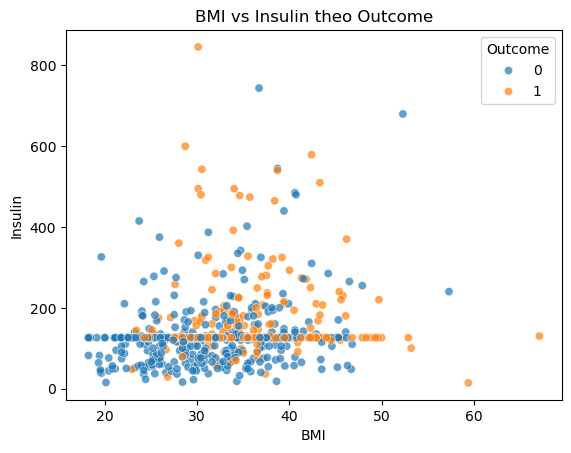

In [42]:
sns.scatterplot(x="BMI", y="Insulin", hue="Outcome", data=df_final, alpha=0.7)
plt.title("BMI vs Insulin theo Outcome")
plt.savefig('4.4.3_insulin.png', dpi=300, bbox_inches='tight')
plt.show()

## PHÂN TÍCH GLUCOSE VÀ INSULIN

### Phân bố nồng độ glucose

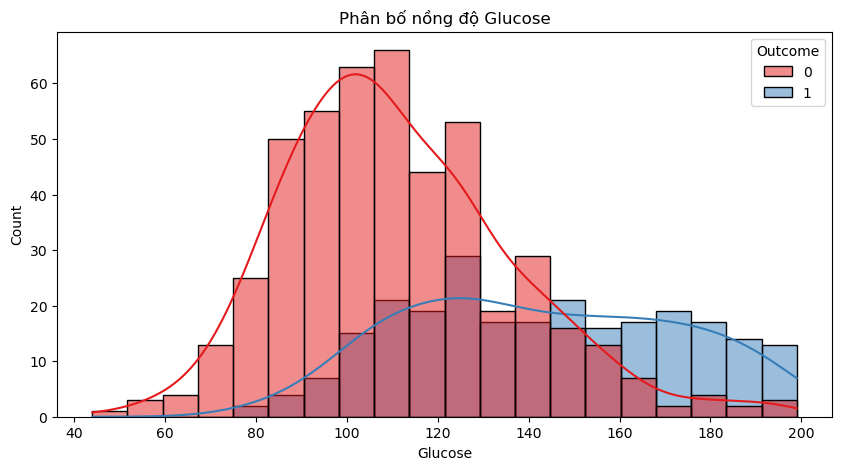

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_final, x="Glucose", hue="Outcome", bins=20, kde=True, palette="Set1")
plt.title("Phân bố nồng độ Glucose")
plt.savefig('4.5.1.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Code tính tỷ lệ theo ngưỡng chẩn đoán
normal = (df_final['Glucose'] < 100).sum()
prediabetes = ((df_final['Glucose'] >= 100) & (df_final['Glucose'] < 126)).sum()
diabetes = (df_final['Glucose'] >= 126).sum()
total = len(df_final)

print("=== PHÂN BỐ THEO TIÊU CHUẨN CHẨN ĐOÁN ===")
print(f"Bình thường (<100 mg/dL): {normal}/{total} ({normal/total*100:.1f}%)")
print(f"Tiền đái tháo đường (100-125 mg/dL): {prediabetes}/{total} ({prediabetes/total*100:.1f}%)")
print(f"Đái tháo đường (≥126 mg/dL): {diabetes}/{total} ({diabetes/total*100:.1f}%)")

# Tìm giá trị phổ biến nhất (mode)
glucose_mode = df_final['Glucose'].mode()[0]
print(f"Giá trị phổ biến nhất (mode): {glucose_mode} mg/dL")

=== PHÂN BỐ THEO TIÊU CHUẨN CHẨN ĐOÁN ===
Bình thường (<100 mg/dL): 179/720 (24.9%)
Tiền đái tháo đường (100-125 mg/dL): 258/720 (35.8%)
Đái tháo đường (≥126 mg/dL): 283/720 (39.3%)
Giá trị phổ biến nhất (mode): 100 mg/dL


In [33]:
# Nhóm tiền đái tháo đường (100-125)
prediabetes_group = df_final[(df_final['Glucose'] >= 100) & (df_final['Glucose'] >=126)]

# Đếm số người có Outcome = 1 trong nhóm này
prediabetes_with_outcome = (prediabetes_group['Outcome'] == 1).sum()

# Tính tỷ lệ %
percentage_prediabetes = prediabetes_with_outcome / len(prediabetes_group) * 100

print(f"Số người Glucose 100-125 và Outcome = 1: {prediabetes_with_outcome}/{len(prediabetes_group)} ({percentage_prediabetes:.1f}%)")


Số người Glucose 100-125 và Outcome = 1: 164/283 (58.0%)


### Mối quan hệ glucose-insulin

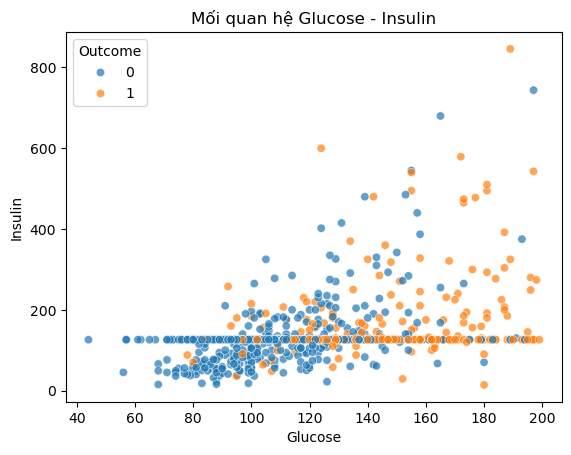

In [104]:
sns.scatterplot(x="Glucose", y="Insulin", hue="Outcome", data=df_final, alpha=0.7)
plt.title("Mối quan hệ Glucose - Insulin")
plt.savefig('4.5.2.png', dpi=300, bbox_inches='tight')
plt.show()

### Ngưỡng glucose trong chẩn đoán

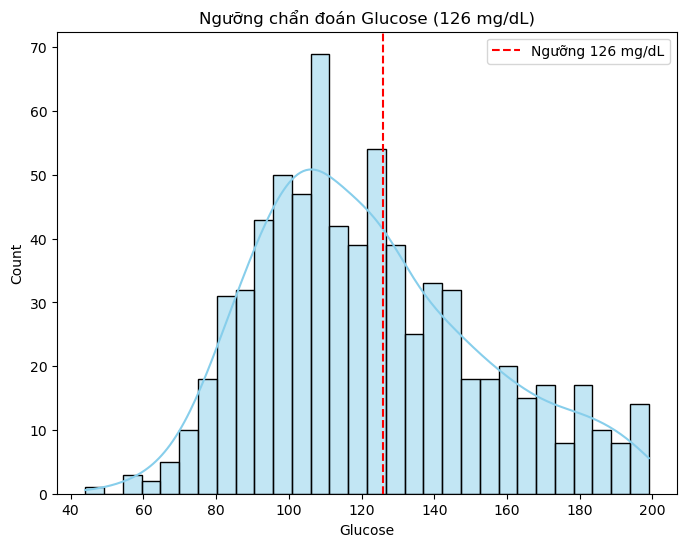

In [105]:
# WHO & ADA: ≥126 mg/dL là tiểu đường
plt.figure(figsize=(8,6))
sns.histplot(df_final["Glucose"], bins=30, kde=True, color="skyblue")
plt.axvline(126, color="red", linestyle="--", label="Ngưỡng 126 mg/dL")
plt.title("Ngưỡng chẩn đoán Glucose (126 mg/dL)")
plt.legend()
plt.savefig('4.5.3.png', dpi=300, bbox_inches='tight')
plt.show()

## PHÂN TÍCH YẾU TỐ DI TRUYỀN

### Hàm phả hệ đái tháo đường

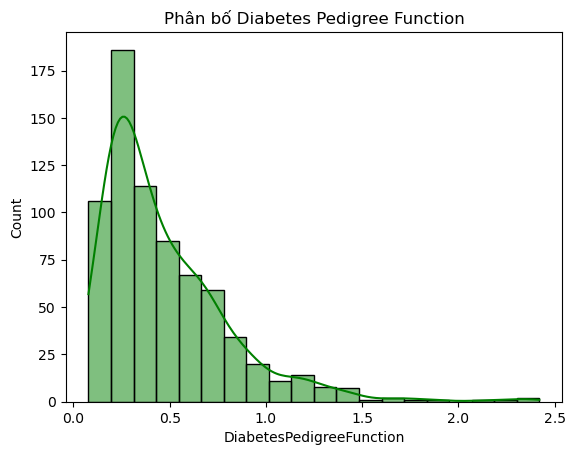

In [106]:
sns.histplot(df_final["DiabetesPedigreeFunction"], bins=20, kde=True, color="green")
plt.title("Phân bố Diabetes Pedigree Function")
plt.savefig('4.6.1.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Phân tích thống kê chi tiết
dpf_stats = df_final['DiabetesPedigreeFunction'].describe()
print("=== THỐNG KÊ DIABETES PEDIGREE FUNCTION ===")
print(dpf_stats)

# Phân tích theo phần trăm
percentiles = df_final['DiabetesPedigreeFunction'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\n=== PHÂN VỊ ===")
for p, value in percentiles.items():
    print(f"{int(p*100)}%: {value:.3f}")

# Phân loại nguy cơ
low_risk = (df_final['DiabetesPedigreeFunction'] < 0.5).sum()
medium_risk = ((df_final['DiabetesPedigreeFunction'] >= 0.5) & (df_final['DiabetesPedigreeFunction'] < 1.0)).sum()
high_risk = (df_final['DiabetesPedigreeFunction'] >= 1.0).sum()
total = len(df_final)

print(f"\n=== PHÂN BỐ THEO MỨC ĐỘ NGUY CƠ ===")
print(f"Nguy cơ thấp (<0.5): {low_risk}/{total} ({(low_risk/total*100):.1f}%)")
print(f"Nguy cơ trung bình (0.5-1.0): {medium_risk}/{total} ({(medium_risk/total*100):.1f}%)")
print(f"Nguy cơ cao (≥1.0): {high_risk}/{total} ({(high_risk/total*100):.1f}%)")

=== THỐNG KÊ DIABETES PEDIGREE FUNCTION ===
count    720.000000
mean       0.475118
std        0.333035
min        0.078000
25%        0.245000
50%        0.378000
75%        0.629500
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

=== PHÂN VỊ ===
25%: 0.245
50%: 0.378
75%: 0.629
90%: 0.882
95%: 1.138
99%: 1.679

=== PHÂN BỐ THEO MỨC ĐỘ NGUY CƠ ===
Nguy cơ thấp (<0.5): 459/720 (63.7%)
Nguy cơ trung bình (0.5-1.0): 211/720 (29.3%)
Nguy cơ cao (≥1.0): 50/720 (6.9%)


### Tác động của yếu tố di truyền

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3167210737.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=df_final, palette="Set2")


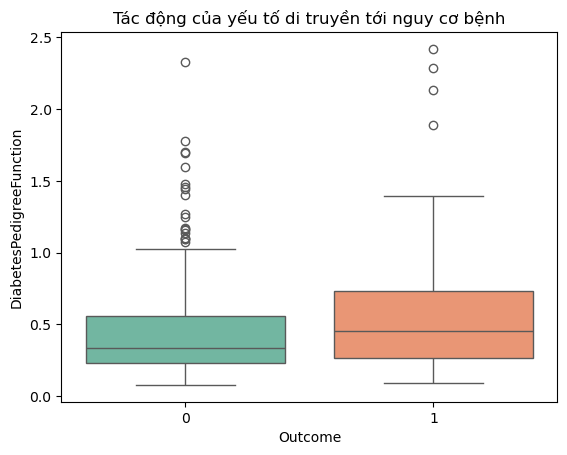

In [107]:
sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=df_final, palette="Set2")
plt.title("Tác động của yếu tố di truyền tới nguy cơ bệnh")
plt.savefig('4.6.2.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# Phân tích thống kê so sánh 2 nhóm
dpf_healthy = df_final[df_final['Outcome'] == 0]['DiabetesPedigreeFunction']
dpf_diabetes = df_final[df_final['Outcome'] == 1]['DiabetesPedigreeFunction']

print("=== SO SÁNH DIABETES PEDIGREE FUNCTION THEO OUTCOME ===")
print(f"Nhóm không mắc: Mean = {dpf_healthy.mean():.3f}, Median = {dpf_healthy.median():.3f}")
print(f"Nhóm mắc bệnh: Mean = {dpf_diabetes.mean():.3f}, Median = {dpf_diabetes.median():.3f}")

# Kiểm định Mann-Whitney (do phân phối không chuẩn)
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(dpf_healthy, dpf_diabetes)
print(f"\nKiểm định Mann-Whitney: p-value = {p_value:.6f}")

# Tính tỷ lệ nguy cơ theo ngưỡng
threshold = 0.8  # Ngưỡng trung bình
high_risk_healthy = (dpf_healthy > threshold).sum()
high_risk_diabetes = (dpf_diabetes > threshold).sum()

print(f"\nTỷ lệ có DPF > {threshold}:")
print(f"- Nhóm không mắc: {high_risk_healthy}/{len(dpf_healthy)} ({(high_risk_healthy/len(dpf_healthy)*100):.1f}%)")
print(f"- Nhóm mắc bệnh: {high_risk_diabetes}/{len(dpf_diabetes)} ({(high_risk_diabetes/len(dpf_diabetes)*100):.1f}%)")

=== SO SÁNH DIABETES PEDIGREE FUNCTION THEO OUTCOME ===
Nhóm không mắc: Mean = 0.431, Median = 0.338
Nhóm mắc bệnh: Mean = 0.560, Median = 0.452

Kiểm định Mann-Whitney: p-value = 0.000001

Tỷ lệ có DPF > 0.8:
- Nhóm không mắc: 48/472 (10.2%)
- Nhóm mắc bệnh: 52/248 (21.0%)


### Kết hợp yếu tố di truyền với các yếu tố khác

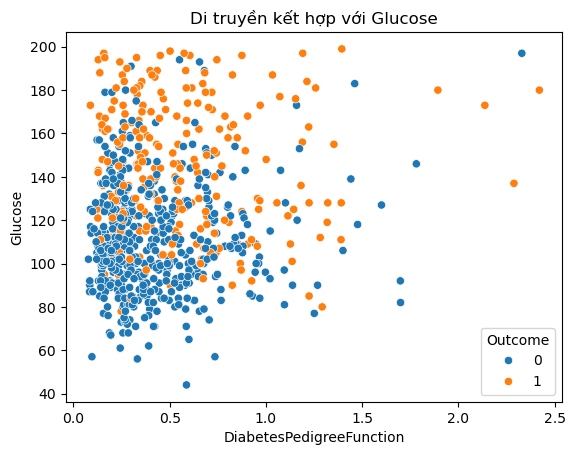

In [56]:
sns.scatterplot(x="DiabetesPedigreeFunction", y="Glucose", hue="Outcome", data=df_final)
plt.title("Di truyền kết hợp với Glucose")
plt.savefig('4.6.3.png', dpi=300, bbox_inches='tight')
plt.show()

## PHÂN TÍCH THEO SỐ LẦN CÓ THAI

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\2782804701.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="Pregnancies", data=df_final, palette="Set2")


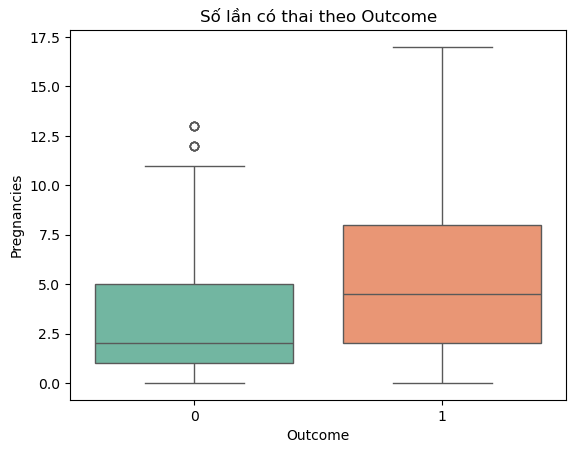

In [110]:
sns.boxplot(x="Outcome", y="Pregnancies", data=df_final, palette="Set2")
plt.title("Số lần có thai theo Outcome")
plt.savefig('4.7.1.png', dpi=300, bbox_inches='tight')
plt.show()

### Tiến triển nguy cơ theo số lần có thai

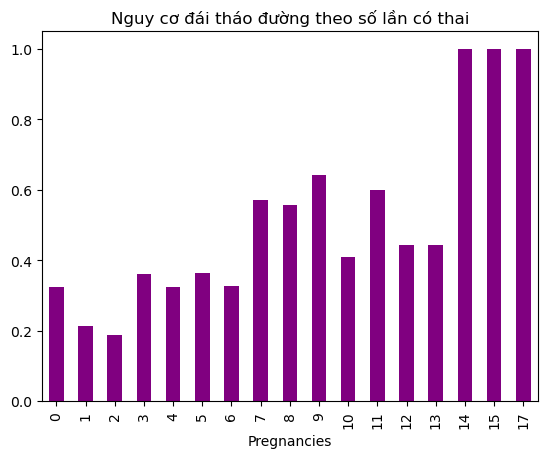

In [111]:
preg_outcome = df_final[df_final["Pregnancies"]>=0].groupby("Pregnancies")["Outcome"].mean()
preg_outcome.plot(kind="bar", color="purple", title="Nguy cơ đái tháo đường theo số lần có thai")
plt.savefig('4.7.2.png', dpi=300, bbox_inches='tight')
plt.show()